In [9]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm
import tqdm
import math
import QuantLib as ql
import numpy_financial as npf
# pip install numpy-financial
import scipy.optimize as optimize
import pandas as pd

# 1. Simulate interest rate

### Vasicek Model

In [2]:
def generate_vasicek(kappa,theta,sigma,r0,WAM,num_paths):
    # Generate interest rate 
    T=WAM/12
    h=1/12
    N=WAM
    size=num_paths
    r=np.ones((1,size))*r0
    zero=np.zeros(size)
    Z1=np.random.normal(0,1,(N,size))
    for i in range(N):
        m=r[i,:]+kappa*(theta-np.max([r[i,:],zero],axis=0))*h+sigma*np.sqrt(np.max([r[i,:],zero],axis=0))*np.sqrt(h)*Z1[i,:]
        r=np.append(r,[m],axis=0)
    return r

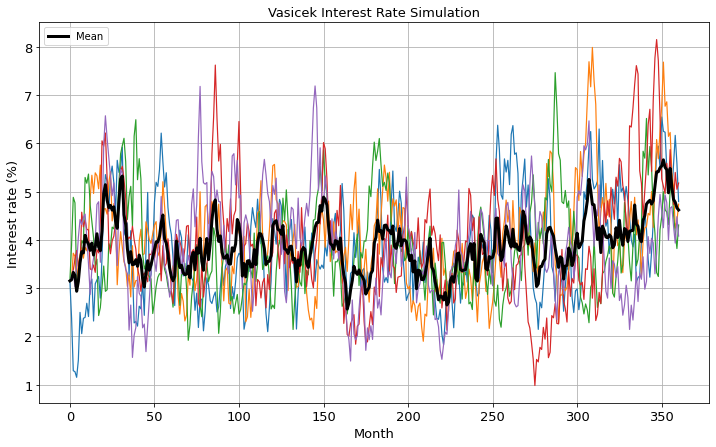

In [3]:
# Simulate
kappa=2
theta=0.039
sigma=0.1
r0=0.0315
num_paths=5
WAM=360
interest_paths=generate_vasicek(kappa,theta,sigma,r0,WAM,num_paths)
interest_paths
time=np.arange(WAM+1)

# mean
test=np.mean(interest_paths,axis=1)

# Plot
plt.figure(figsize=(12,7))
for i in range(num_paths):
    plt.plot(time,interest_paths[:,i]*100, lw=1.2)
p1=plt.plot(test*100,color='black',lw=3,label='Mean')
plt.title("Vasicek Interest Rate Simulation",fontsize=13)
plt.xlabel("Month",fontsize=13)
plt.ylabel("Interest rate (%)",fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()
plt.grid()
plt.show()

### Hull-White

In [4]:
ql.Thirty360()

<QuantLib.QuantLib.Thirty360; proxy of <Swig Object of type 'QuantLib::Thirty360 *' at 0x0000021A05C4F480> >

In [5]:
# For Hull-White
sigma = 0.1
a = 0.1

timestep = 360
length = 30 # 30 years
forward_rate = 0.03
day_count = ql.Thirty360()
todays_date = ql.Date(12,6,2022) # 2022/6/12

ql.Settings.instance().evaluationDate = todays_date
spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hw_process, length, timestep, rng, False)

In [6]:
def generate_paths(num_paths, timestep):
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr

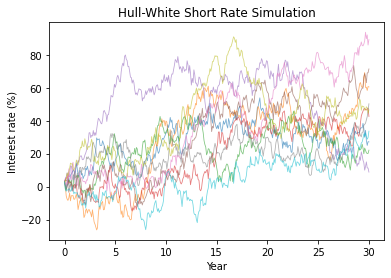

In [7]:
num_paths = 10
time, paths = generate_paths(num_paths, timestep)

for i in range(num_paths):
    plt.plot(time, paths[i, :]*100, lw=0.8, alpha=0.6)
plt.title("Hull-White Short Rate Simulation")
plt.xlabel("Year")
plt.ylabel("Interest rate (%)")
plt.show()

# 2. Prepayment

In [ ]:
# Prepayment Model

WAC=0.045 # Need to revise
B0=1000000
B=np.ones((1,size))*B0 # Need to revise
for i in range(N-1):
    n=B[-1,:]*0.8
    B=np.append(B,[n],axis=0)

# Refinancing incentive
max_cpr=0.5
min_cpr=0
mid_diff_cpr=0.02
mid_max_slope=0.06/0.001
a=(max_cpr+min_cpr)/2
b=100*(max_cpr-a)/(np.pi/2)
d=mid_max_slope/b
c=-d*mid_diff_cpr
RI=a+b*np.arctan(c+d*(WAC-r[1:,:])) # Formulas from Davidson/Herskovitz (1996).

# Seasoning multiplier
t=np.ones((1,size))
for i in range(N-1):
    o=t[-1,:]+1
    t=np.append(t,[o],axis=0)
Age=np.min([t/30,np.ones((N,size))],axis=0)

# Monthly multiplier
temp=np.array([[0.94,0.76,0.74,0.95,0.98,0.92,0.98,1.10,1.18,1.22,1.23,0.98]])
testf=np.ones((1,N))
temp1=[]
for i in range(len(testf[0])):
    index=math.floor(i/21)
    temp2=testf[0][index]*temp[0][index]
    temp1=np.append(temp1,temp2)
MM=np.ones((N,size))*(np.array([temp1]).T)

# Burnout multiplier
BM=0.3+0.7*(B/B0)

# CPR
CPR=np.maximum(RI*Age*MM*BM,np.zeros((N,size)))

In [ ]:
# Plot RI
RI_mean=np.mean(RI,axis=1)
plt.figure(figsize=(7,5))
plt.plot(RI_mean,color='red')
plt.title('Refinancing Incentive',fontsize=13)
plt.xlabel('Day',fontsize = 10)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10)
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.show()

In [ ]:
# Plot Seasoning multiplier
Age_mean=np.mean(Age,axis=1)
plt.figure(figsize=(7,5))
plt.plot(Age_mean,color='red')
plt.title('Seasoning multiplier',fontsize=13)
plt.xlabel('Day',fontsize = 10)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10)
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.show()

In [ ]:
# Plot Monthly multiplier
MM_mean=np.mean(MM,axis=1)
plt.figure(figsize=(7,5))
plt.plot(MM_mean,color='red')
plt.title('Monthly Multiplier',fontsize=13)
plt.xlabel('Day',fontsize = 10)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10)
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.show()

In [ ]:
# Plot Burnout multiplier
BM_mean=np.mean(BM,axis=1)
plt.figure(figsize=(7,5))
plt.plot(BM_mean,color='red')
plt.title('Burnout Multiplier',fontsize=13)
plt.xlabel('Day',fontsize = 10)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10)
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.show()

In [ ]:
# Plot CPR
CPR_mean=np.mean(CPR,axis=1)
plt.figure(figsize=(7,5))
plt.plot(CPR_mean,color='red')
plt.title('CPR (Annualized)',fontsize=13)
plt.xlabel('Day',fontsize = 10)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10)
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.show()

# 3. Cash flow

### Generate cash flow table template:

In [10]:
# Generating cash flow
B0=3817752472
WAM_month=360
WAC_month=0.045/12
CPR=0.04

# genarate period / date series
period=np.zeros(WAM_month+1)
for i in range(WAM_month+1):
    period[i]+=i
# pd.Series(period)

MB=np.ones(WAM_month+1)*B0
# pd.Series(MB)

# generate SMM (only for constant CPR)
SMM=1-np.power(1-CPR,1/12)

# generate Mortgage payment
MP0=-1*npf.pmt(rate=WAC_month,nper=WAM_month-1,pv=B0)
MP=np.ones(WAM_month+1)*MP0

# generate interest payment
IP=MB*WAC_month

# generate principal paying in mortgage payment
PrinP=MP-IP

# generate prepayment in mortgage payment
PrePay=(MB-PrinP)*SMM

# generate cash flow 
CF=MP+PrePay

# Make a data frame
frame = {'Time':pd.Series(period),'Mortgage_Balance':pd.Series(MB),
         'Mortgage_Payment':pd.Series(MP), 'Interest_Payment':pd.Series(IP),
         'Principal_Payment':pd.Series(PrinP), 'Prepayment':pd.Series(PrePay),
         'Cash Flow':pd.Series(CF)}
df=pd.DataFrame(frame)

### Calculate cash flow until maturaity

In [11]:
for i in range(1,df.shape[0]-1):
    # MB
    df.iloc[i,1]=df.iloc[i-1,1]-df.iloc[i-1,4]-df.iloc[i-1,5]
    # MP
    df.iloc[i,2]=-1*npf.pmt(rate=WAC_month,nper=WAM_month-df.iloc[i,0],pv=df.iloc[i,1])
    # IP
    df.iloc[i,3]=df.iloc[i-1,1]*WAC_month
    # PP
    df.iloc[i,4]=df.iloc[i,2]-df.iloc[i,3]
    # Prepay
    df.iloc[i,5]=(df.iloc[i,1]-df.iloc[i,4])*SMM
    # SMM=(df.iloc[i-1,1]-df.iloc[i-1,2]-df.iloc[i,1])/(df.iloc[i-1,1]-df.iloc[i-1,2])
    # Cashflow
    df.iloc[i,6]=df.iloc[i,3]+df.iloc[i,4]+df.iloc[i,5]
# MB
df.iloc[-1,1]=0
# MP
df.iloc[-1,2]=df.iloc[-2,1]+df.iloc[-2,1]*WAC_month
# IP
df.iloc[-1,3]=df.iloc[-2,1]*WAC_month
# PP
df.iloc[-1,4]=df.iloc[-2,1]
# Prepay
df.iloc[-1,5]=0
# SMM=(df.iloc[i-1,1]-df.iloc[i-1,2]-df.iloc[i,1])/(df.iloc[i-1,1]-df.iloc[i-1,2])
# Cashflow
df.iloc[-1,6]=df.iloc[i,3]+df.iloc[i,4]+df.iloc[i,5]

In [12]:
df

,Time,Mortgage_Balance,Mortgage_Payment,Interest_Payment,Principal_Payment,Prepayment,Cash Flow
0,0.0,3.817752e+09,1.936950e+07,1.431657e+07,5.052926e+06,1.294813e+07,3.231763e+07
1,1.0,3.799751e+09,1.927817e+07,1.431657e+07,4.961597e+06,1.288731e+07,3.216548e+07
2,2.0,3.781903e+09,1.921304e+07,1.424907e+07,4.963973e+06,1.282668e+07,3.203973e+07
3,3.0,3.764112e+09,1.914813e+07,1.418213e+07,4.965997e+06,1.276626e+07,3.191439e+07
4,4.0,3.746380e+09,1.908344e+07,1.411542e+07,4.968023e+06,1.270603e+07,3.178948e+07
...,...,...,...,...,...,...,...
356,356.0,2.328655e+07,5.876319e+06,1.092208e+05,5.767098e+06,5.949701e+04,5.935816e+06
357,357.0,1.745996e+07,5.863691e+06,8.732458e+04,5.776366e+06,3.967810e+04,5.903369e+06
358,358.0,1.164392e+07,5.854726e+06,6.547485e+04,5.789252e+06,1.988275e+04,5.874609e+06
359,359.0,5.834781e+06,5.856661e+06,4.366468e+04,5.812996e+06,7.398048e+01,5.856735e+06


# 4. MBS Valuation

### Present Value, YTM, quotes, and duration

In [13]:
def Bond_price_YTM_duration(discount,CF,B0,WAC_month,period):
    PV=npf.npv(discount,CF) # This function start from time 0
    guess=0.001
    coupon=B0*WAC_month
    
    ytm_func = lambda y: \
        sum([coupon/(1+y)**(t) for t in period[1:]]) + \
        B0/(1+y)**(period[-1]) - PV
    ytm=optimize.newton(ytm_func, guess)
    
    bond_quotes=(PV/B0)*100
    print("Quotes: {}".format(bond_quotes))
    print("Yield to Maturity:  %.2f%%" % (ytm*1200))
    
    Duration=npf.npv(ytm,period*CF)/PV
    print("Duration (years): {}".format(Duration/12))
    return bond_quotes,ytm,Duration

In [14]:
bond_quotes,ytm,Duration=Bond_price_YTM_duration(discount=0.03/12,CF=df['Cash Flow'],B0=B0,WAC_month=WAC_month,period=period)

Quotes: 114.88701629459621
Yield to Maturity:  3.68%
Duration (years): 8.354184463145746


In [15]:
# Adjust YTM
ytm_list=np.arange(0.02,0.08,0.0001)/12 # monthly
coupon=B0*WAC_month
bond_price_list=np.ones(len(ytm_list))
for i in range(len(ytm_list)):
    y=ytm_list[i]
    bond_price=sum([coupon/(1+y)**(t) for t in period[1:]])+B0/(1+y)**(period[-1])
    bond_price_list[i]=(bond_price/B0)*100

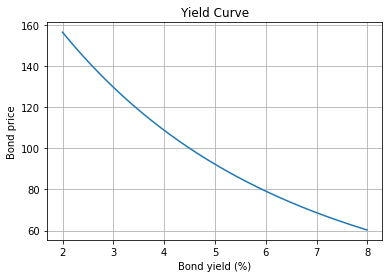

In [16]:
plt.title('Yield Curve')
plt.plot(ytm_list*1200,bond_price_list)
plt.xlabel('Bond yield (%)')
plt.ylabel('Bond price')
plt.grid()
plt.show()